In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
from openai import OpenAI
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA

In [2]:
import math

In [3]:
api_key = "API_KEY"
client = OpenAI(api_key = api_key)

In [4]:
def get_embedding(text, model = "text-embedding-3-small"):
    response = client.embeddings.create(input=text, model=model, dimensions = 512)
    return response.data[0].embedding

In [5]:
con_space_withFBloop_ConMemoNo_gpt4o = pd.read_csv('main_data\con-space_withFBloop_ConMemNo-gpt4o.csv')
con_space_withFBloop_ConMemoYes_gpt4o = pd.read_csv('main_data\con-space_withFBloop_ConMemYes-gpt4o.csv')
con_space_withoutFBloop_ConMemoYes_gpt4o = pd.read_csv('main_data\con-space_withoutFBloop_ConMemYes-gpt4o.csv')
con_space_withoutFBloop_ConMemoNo_gpt4o = pd.read_csv('main_data\con-space_withoutFBloop_ConMemNo-gpt4o.csv')

with open('main_data\past_transitions_withFBloop_ConMemNo-gpt4o.pkl', 'rb') as file:
    past_transitions_withFBloop_ConMemoNo_gpt4o = pickle.load(file)
with open('main_data\past_transitions_withFBloop_ConMemYes-gpt4o.pkl', 'rb') as file:
    past_transitions_withFBloop_ConMemoYes_gpt4o = pickle.load(file)
with open('main_data\past_transitions_withoutFBloop_ConMemYes-gpt4o.pkl', 'rb') as file:
    past_transitions_withoutFBloop_ConMemoYes_gpt4o = pickle.load(file)
with open('main_data\past_transitions_withoutFBloop_ConMemNo-gpt4o.pkl', 'rb') as file:
    past_transitions_withoutFBloop_ConMemoNo_gpt4o = pickle.load(file)
    
with open('main_data/avg_iter_sim_withFBloop_ConMemNo-gpt4o.pkl', 'rb') as file:
    avg_sim_withFBloop_ConMemoNo_gpt4o = pickle.load(file)
with open('main_data/avg_iter_sim_withFBloop_ConMemYes-gpt4o.pkl', 'rb') as file:
    avg_sim_withFBloop_ConMemoYes_gpt4o = pickle.load(file)
with open('main_data/avg_iter_sim_withoutFBloop_ConMemYes-gpt4o.pkl', 'rb') as file:
    avg_sim_withoutFBloop_ConMemoYes_gpt4o = pickle.load(file)
with open('main_data/avg_iter_sim_withoutFBloop_ConMemNo-gpt4o.pkl', 'rb') as file:
    avg_sim_withoutFBloop_ConMemoNo_gpt4o = pickle.load(file)

In [6]:
con_space_withFBloop_ConMemoNo_gpt45 = pd.read_csv('main_data\con-space_withFBloop_ConMemNo-gpt4.5 (2).csv')
con_space_withFBloop_ConMemoYes_gpt45 = pd.read_csv('main_data\con-space_withFBloop_ConMemYes-gpt4.5.csv')
con_space_withoutFBloop_ConMemoYes_gpt45 = pd.read_csv('main_data\con-space_withoutFBloop_ConMemYes-gpt4.5.csv')
con_space_withoutFBloop_ConMemoNo_gpt45 = pd.read_csv('main_data\con-space_withoutFBloop_ConMemNo-gpt4.5.csv')

with open('main_data\past_transitions_withFBloop_ConMemNo-gpt4.5.pkl', 'rb') as file:
    past_transitions_withFBloop_ConMemoNo_gpt45 = pickle.load(file)
with open('main_data\past_transitions_withFBloop_ConMemYes-gpt4.5.pkl', 'rb') as file:
    past_transitions_withFBloop_ConMemoYes_gpt45 = pickle.load(file)
with open('main_data\past_transitions_withoutFBloop_ConMemYes-gpt4.5.pkl', 'rb') as file:
    past_transitions_withoutFBloop_ConMemoYes_gpt45 = pickle.load(file)
with open('main_data\past_transitions_withoutFBloop_ConMemNo-gpt4.5.pkl', 'rb') as file:
    past_transitions_withoutFBloop_ConMemoNo_gpt45 = pickle.load(file)
    
with open('main_data/avg_iter_sim_withFBloop_ConMemNo-gpt4.5 (2).pkl', 'rb') as file:
    avg_sim_withFBloop_ConMemoNo_gpt45 = pickle.load(file)
with open('main_data/avg_iter_sim_withFBloop_ConMemYes-gpt4.5.pkl', 'rb') as file:
    avg_sim_withFBloop_ConMemoYes_gpt45 = pickle.load(file)
with open('main_data/avg_iter_sim_withoutFBloop_ConMemYes-gpt4.5.pkl', 'rb') as file:
    avg_sim_withoutFBloop_ConMemoYes_gpt45 = pickle.load(file)
with open('main_data/avg_iter_sim_withoutFBloop_ConMemNo-gpt4.5.pkl', 'rb') as file:
    avg_sim_withoutFBloop_ConMemoNo_gpt45 = pickle.load(file)

In [7]:
# more negative value sugests smaller eigen values. In the DPP context, smaller eigen values indicate more spread out 
def DPP_diversity(x, lambda0=0):
    x = np.array(x)
    # Normalize the rows of x to have unit norm
    x_normalized = x / np.linalg.norm(x, axis=1, keepdims=True)
    
    # Compute the cosine similarity matrix Slog 
    S = np.dot(x_normalized, x_normalized.T)
    
    # Transform cosine similarity values to be non-negative
    S_non_negative = (S + 1.0) / 2.0
    
    # Create a vector of ones with the same length as the number of points in x
    y = np.ones(x.shape[0])
    
    # Compute the outer product of y with itself
    Q = np.outer(y, y)
    
    if lambda0 == 0:
        L = S_non_negative
    else:
        L = S * np.power(Q, lambda0)
    
    try:
        eig_val = np.linalg.eigh(L)[0]
    except np.linalg.LinAlgError:
        eig_val = np.ones_like(y)
    
    loss = np.mean(np.log(np.maximum(eig_val, 1e-7)))
    return loss

In [8]:
def L2_vectorized(X, Y):
    #Vectorize L2 calculation using x^2+y^2-2xy
    X_sq = np.sum(np.square(X), axis=1)
    Y_sq = np.sum(np.square(Y), axis=1)
    sq = np.add(np.expand_dims(X_sq, axis=-1), np.transpose(Y_sq)) - 2*np.matmul(X,np.transpose(Y))
    sq = np.clip(sq, 0.0, 1e12)
    return np.sqrt(sq)

In [9]:
def distance_to_centroid(embeddings, n_components=9):
    # Apply PCA
    pca = PCA(n_components=n_components)
    transformed_embeddings = pca.fit_transform(embeddings)
    
    # Compute the centroid of the transformed embeddings
    centroid = np.mean(transformed_embeddings, axis=0)
    
    # Calculate the distance of each embedding to the centroid
    distances = [
        np.linalg.norm(embedding - centroid)
        for embedding in transformed_embeddings
    ]
    
    # Return the average distance
    return np.mean(distances)

## Average Similarity Plots

In [10]:
def calculate_weighted_sim(similarity_list):
    weights_lst = []
    for sublist in similarity_list:
        if len(sublist) <= 1:
            pass
        else:
            num_con = len(sublist)
            num_pairs = num_con*(num_con-1)/2
            # logging factor
            weight = 1/math.log(num_pairs+1)
            weights_lst.append(weight)
        
    total_weight = sum(weights_lst)
    normalized_weights = [w/total_weight for w in weights_lst]

    # to calculate weighted cosine similarity
    similarity_weighted = []
    iteration = 0
    for sublist in similarity_list:
        if len(sublist) <= 1:
            similarity_weighted.append(sublist)
        else:
            sim_score = sum(sublist)/len(sublist)*normalized_weights[iteration]
            iteration += 1
            similarity_weighted.append(sim_score)
    return similarity_weighted


In [11]:
def calculate_avg_sim(similarity_list):
    sim = []
    for sublist in similarity_list:
        sim.append(sum(sublist)/len(sublist))
    return sim

In [12]:
avg_iter_sim_withFBloop_ConMemNo_lst4o = calculate_avg_sim(avg_sim_withFBloop_ConMemoNo_gpt4o)
avg_iter_sim_withFBloop_ConMemYes_lst4o = calculate_avg_sim(avg_sim_withFBloop_ConMemoYes_gpt4o)
avg_iter_sim_withoutFBloop_ConMemYes_lst4o = calculate_avg_sim(avg_sim_withoutFBloop_ConMemoYes_gpt4o)
avg_iter_sim_withoutFBloop_ConMemNo_lst4o = calculate_avg_sim(avg_sim_withoutFBloop_ConMemoNo_gpt4o)

In [13]:
avg_iter_sim_withFBloop_ConMemNo_lst45 = [sum(sublist)/len(sublist) for sublist in avg_sim_withFBloop_ConMemoNo_gpt45]
avg_iter_sim_withFBloop_ConMemYes_lst45 = [sum(sublist)/len(sublist) for sublist in avg_sim_withFBloop_ConMemoYes_gpt45]
avg_iter_sim_withoutFBloop_ConMemYes_lst45 = [sum(sublist)/len(sublist) for sublist in avg_sim_withoutFBloop_ConMemoYes_gpt45]
avg_iter_sim_withoutFBloop_ConMemNo_lst45 = [sum(sublist)/len(sublist) for sublist in avg_sim_withoutFBloop_ConMemoNo_gpt45]

## Plots for Past Transformations

In [14]:
def build_states(transitions):
    states = ['C']  # Assuming all start with 'C'
    for transition in transitions:
        new_state = transition.split('-->')[1]
        states.append(new_state)
    return states

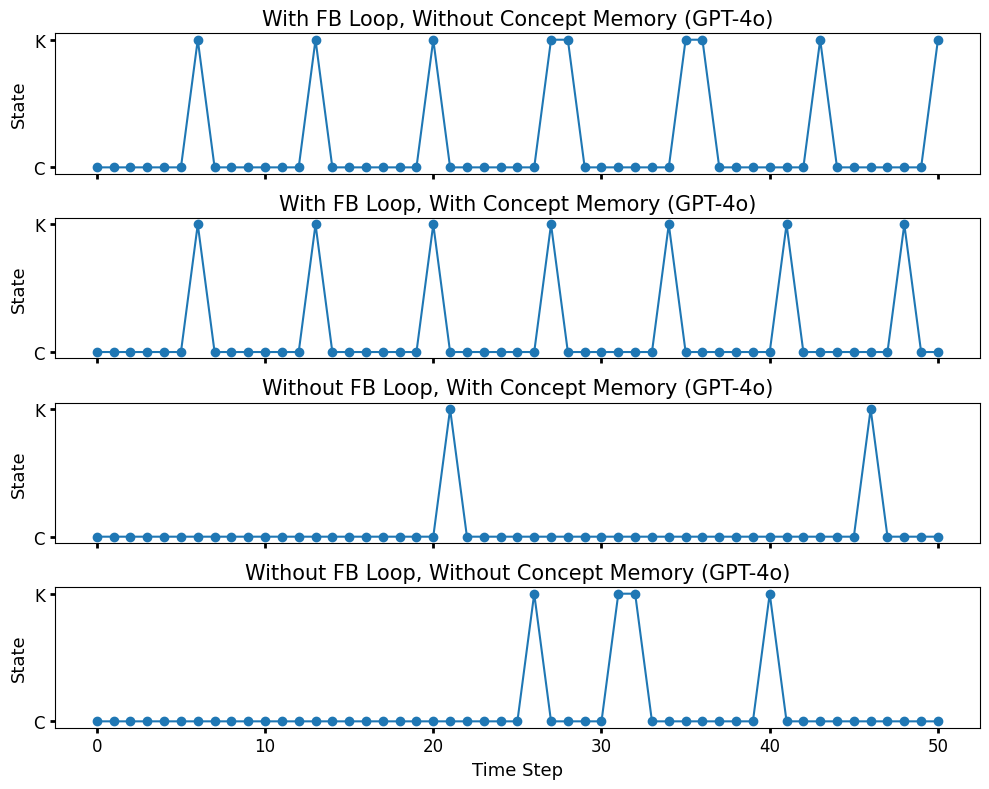

In [20]:
states_1 = build_states(past_transitions_withFBloop_ConMemoNo_gpt4o)
states_2 = build_states(past_transitions_withFBloop_ConMemoYes_gpt4o)
states_3 = build_states(past_transitions_withoutFBloop_ConMemoYes_gpt4o)
states_4 = build_states(past_transitions_withoutFBloop_ConMemoNo_gpt4o)

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True, sharey=True)

# Plot each set on a separate subplot
axs[0].plot(range(len(states_1)), states_1, marker='o', linestyle='-')
axs[0].set_title('With FB Loop, Without Concept Memory (GPT-4o)', fontsize = 15)

axs[1].plot(range(len(states_2)), states_2, marker='o', linestyle='-')
axs[1].set_title('With FB Loop, With Concept Memory (GPT-4o)', fontsize = 15)

axs[2].plot(range(len(states_3)), states_3, marker='o', linestyle='-')
axs[2].set_title('Without FB Loop, With Concept Memory (GPT-4o)', fontsize = 15)

axs[3].plot(range(len(states_4)), states_4, marker='o', linestyle='-')
axs[3].set_title('Without FB Loop, Without Concept Memory (GPT-4o)', fontsize = 15)

# Customize the subplots
for ax in axs:
    ax.set_yticks(['C', 'K'])
#     ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel('State', fontsize = 13)
    ax.tick_params(axis='both', which='major', labelsize=12, width = 2)

axs[-1].set_xlabel('Time Step', fontsize = 13)

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

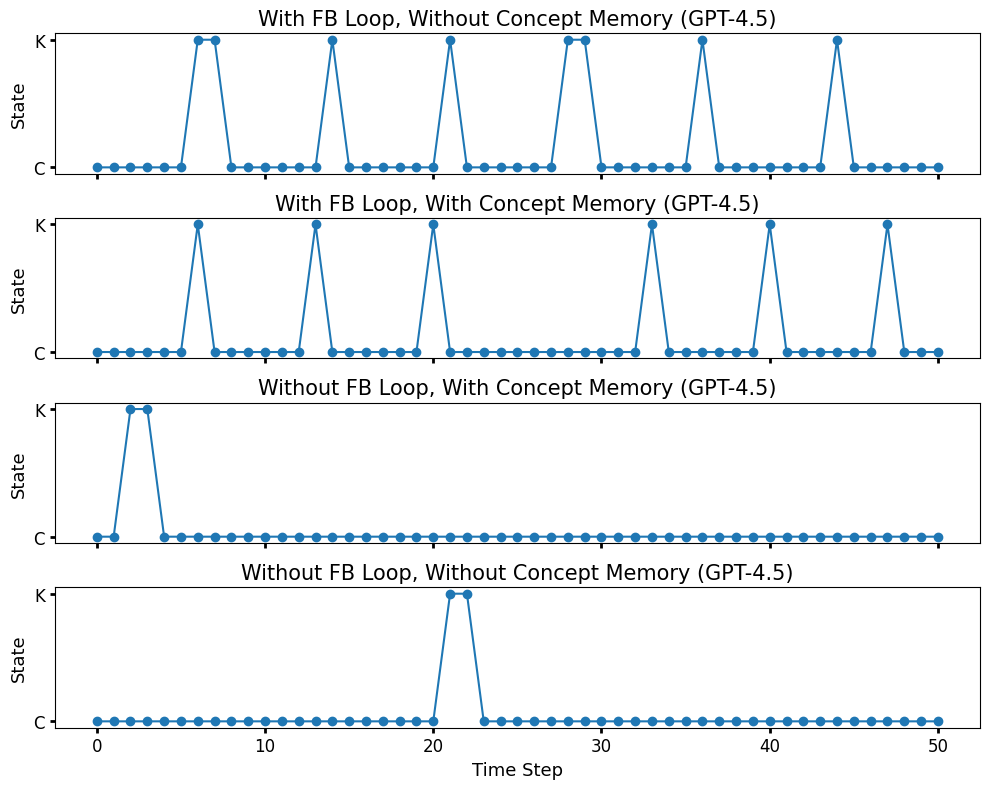

In [21]:
states_1 = build_states(past_transitions_withFBloop_ConMemoNo_gpt45)
states_2 = build_states(past_transitions_withFBloop_ConMemoYes_gpt45)
states_3 = build_states(past_transitions_withoutFBloop_ConMemoYes_gpt45)
states_4 = build_states(past_transitions_withoutFBloop_ConMemoNo_gpt45)

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True, sharey=True)

# Plot each set on a separate subplot
axs[0].plot(range(len(states_1)), states_1, marker='o', linestyle='-')
axs[0].set_title('With FB Loop, Without Concept Memory (GPT-4.5)', fontsize = 15)

axs[1].plot(range(len(states_2)), states_2, marker='o', linestyle='-')
axs[1].set_title('With FB Loop, With Concept Memory (GPT-4.5)', fontsize = 15)

axs[2].plot(range(len(states_3)), states_3, marker='o', linestyle='-')
axs[2].set_title('Without FB Loop, With Concept Memory (GPT-4.5)', fontsize = 15)

axs[3].plot(range(len(states_4)), states_4, marker='o', linestyle='-')
axs[3].set_title('Without FB Loop, Without Concept Memory (GPT-4.5)', fontsize = 15)

# Customize the subplots
for ax in axs:
    ax.set_yticks(['C', 'K'])
#     ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel('State', fontsize = 13)
    ax.tick_params(axis='both', which='major', labelsize=12, width = 2)

axs[-1].set_xlabel('Time Step', fontsize = 13)

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

## Bar Plot for Diversity Ratings

In [17]:
def group_concepts(concepts):
    grouped_concepts = []
    for i in range(len(concepts)):
        grouped_concepts.append(concepts[:i+1])
    return grouped_concepts

In [20]:
x = group_concepts(con_space_withFBloop_ConMemoNo_embd4o)

In [12]:
con_space_withFBloop_ConMemoNo_embd4o = con_space_withFBloop_ConMemoNo_gpt4o['concepts'].apply(get_embedding).tolist()
con_space_withFBloop_ConMemoYes_embd4o = con_space_withFBloop_ConMemoYes_gpt4o['concepts'].apply(get_embedding).tolist()
con_space_withoutFBloop_ConMemoYes_embd4o = con_space_withoutFBloop_ConMemoYes_gpt4o['concepts'].apply(get_embedding).tolist()
con_space_withoutFBloop_ConMemoNo_embd4o = con_space_withoutFBloop_ConMemoNo_gpt4o['concepts'].apply(get_embedding).tolist()

In [13]:
con_space_withFBloop_ConMemoNo_embd45 = con_space_withFBloop_ConMemoNo_gpt45['concepts'].apply(get_embedding).tolist()
con_space_withFBloop_ConMemoYes_embd45 = con_space_withFBloop_ConMemoYes_gpt45['concepts'].apply(get_embedding).tolist()
con_space_withoutFBloop_ConMemoYes_embd45 = con_space_withoutFBloop_ConMemoYes_gpt45['concepts'].apply(get_embedding).tolist()
con_space_withoutFBloop_ConMemoNo_embd45 = con_space_withoutFBloop_ConMemoNo_gpt45['concepts'].apply(get_embedding).tolist()

In [14]:
def compute_dpp(embeddings):
    dpp_values = []
    grouped_embeddings = group_concepts(embeddings)
    for i in range(len(grouped_embeddings)):
        if len(grouped_embeddings[i]) <= 10: 
            dpp_values.append(0)
        else: 
            dpp_value = DPP_diversity(grouped_embeddings[i])
            dpp_values.append(dpp_value)
        
    return dpp_values

In [15]:
def compute_centroid(embeddings):
    centroid_values = []
    grouped_embeddings = group_concepts(embeddings)
    for i in range(len(grouped_embeddings)):
        if len(grouped_embeddings[i]) <= 10: 
            centroid_values.append(0)
        else: 
            distance_value = distance_to_centroid(grouped_embeddings[i])
            centroid_values.append(distance_value)
        
    return centroid_values

In [18]:
dpp_1 = compute_dpp(con_space_withFBloop_ConMemoNo_embd4o)
dpp_2 = compute_dpp(con_space_withFBloop_ConMemoYes_embd4o)
dpp_3 = compute_dpp(con_space_withoutFBloop_ConMemoYes_embd4o)
dpp_4 = compute_dpp(con_space_withoutFBloop_ConMemoNo_embd4o)

dpp_a = compute_dpp(con_space_withFBloop_ConMemoNo_embd45)
dpp_b = compute_dpp(con_space_withFBloop_ConMemoYes_embd45)
dpp_c = compute_dpp(con_space_withoutFBloop_ConMemoYes_embd45)
dpp_d = compute_dpp(con_space_withoutFBloop_ConMemoNo_embd45)

In [19]:
centroid_1 = compute_centroid(con_space_withFBloop_ConMemoNo_embd4o)
centroid_2 = compute_centroid(con_space_withFBloop_ConMemoYes_embd4o)
centroid_3 = compute_centroid(con_space_withoutFBloop_ConMemoYes_embd4o)
centroid_4 = compute_centroid(con_space_withoutFBloop_ConMemoNo_embd4o)

centroid_a = compute_centroid(con_space_withFBloop_ConMemoNo_embd45)
centroid_b = compute_centroid(con_space_withFBloop_ConMemoYes_embd45)
centroid_c = compute_centroid(con_space_withoutFBloop_ConMemoYes_embd45)
centroid_d = compute_centroid(con_space_withoutFBloop_ConMemoNo_embd45)

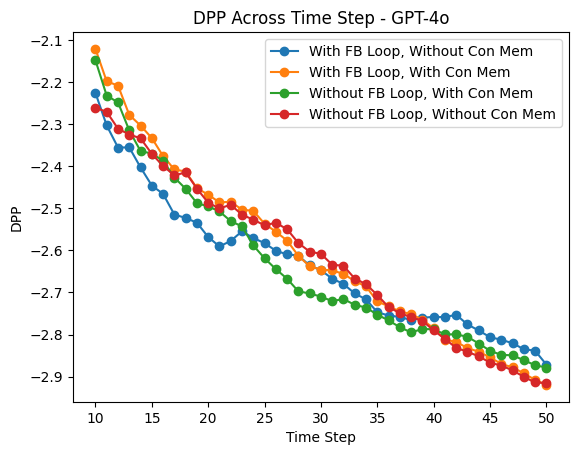

In [24]:
# Plotting the first line
plt.plot(range(10, len(dpp_1)), dpp_1[10:], marker='o', label='With FB Loop, Without Con Mem')

# Plotting the second line
plt.plot(range(10, len(dpp_2)), dpp_2[10:], marker='o', label='With FB Loop, With Con Mem')

# Plotting the third line
plt.plot(range(10, len(dpp_3)), dpp_3[10:], marker='o', label='Without FB Loop, With Con Mem')

# Plotting the fourth line
plt.plot(range(10, len(dpp_4)), dpp_4[10:], marker='o', label='Without FB Loop, Without Con Mem')

# Adding labels and title
plt.xlabel('Time Step')
plt.ylabel('DPP')
plt.title('DPP Across Time Step - GPT-4o')


# Adding the legend
plt.legend()

# Displaying the plot
plt.show()

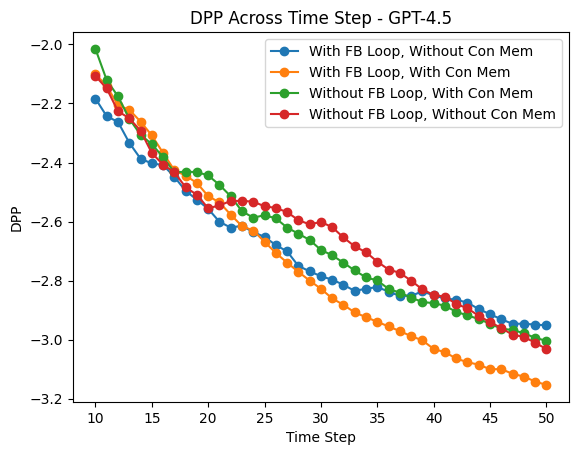

In [26]:
# Plotting the first line
plt.plot(range(10, len(dpp_a)), dpp_a[10:], marker='o', label='With FB Loop, Without Con Mem')

# Plotting the second line
plt.plot(range(10, len(dpp_b)), dpp_b[10:], marker='o', label='With FB Loop, With Con Mem')

# Plotting the third line
plt.plot(range(10, len(dpp_c)), dpp_c[10:], marker='o', label='Without FB Loop, With Con Mem')

# Plotting the fourth line
plt.plot(range(10, len(dpp_d)), dpp_d[10:], marker='o', label='Without FB Loop, Without Con Mem')

# Adding labels and title
plt.xlabel('Time Step')
plt.ylabel('DPP')
plt.title('DPP Across Time Step - GPT-4.5')

# Adding the legend
plt.legend()

# Displaying the plot
plt.show()

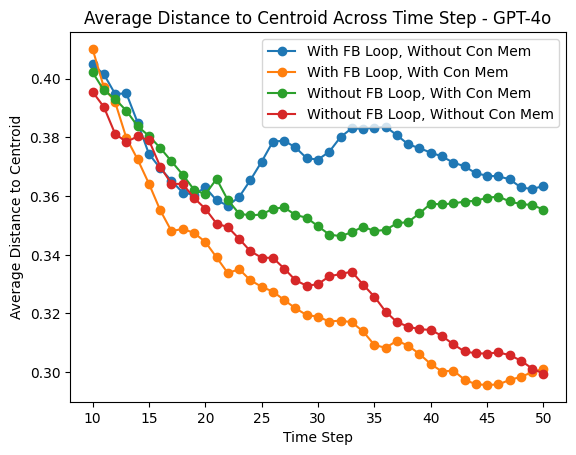

In [27]:
# Plotting the first line
plt.plot(range(10, len(centroid_1)), centroid_1[10:], marker='o', label='With FB Loop, Without Con Mem')

# Plotting the second line
plt.plot(range(10, len(centroid_2)), centroid_2[10:], marker='o', label='With FB Loop, With Con Mem')

# Plotting the third line
plt.plot(range(10, len(centroid_3)), centroid_3[10:], marker='o', label='Without FB Loop, With Con Mem')

# Plotting the fourth line
plt.plot(range(10, len(centroid_4)), centroid_4[10:], marker='o', label='Without FB Loop, Without Con Mem')

# Adding labels and title
plt.xlabel('Time Step')
plt.ylabel('Average Distance to Centroid')
plt.title('Average Distance to Centroid Across Time Step - GPT-4o')

# Adding the legend
plt.legend()

# Displaying the plot
plt.show()

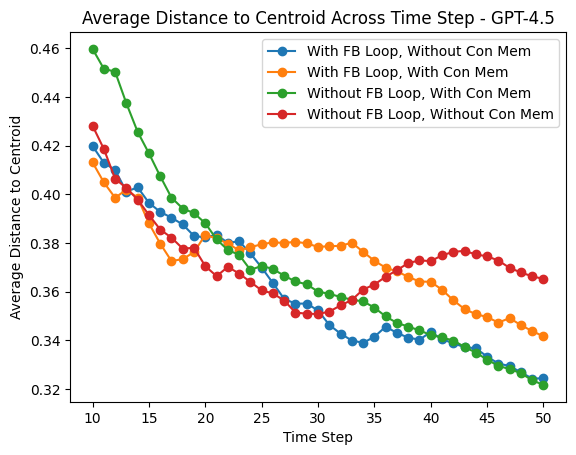

In [28]:
# Plotting the first line
plt.plot(range(10, len(centroid_a)), centroid_a[10:], marker='o', label='With FB Loop, Without Con Mem')

# Plotting the second line
plt.plot(range(10, len(centroid_b)), centroid_b[10:], marker='o', label='With FB Loop, With Con Mem')

# Plotting the third line
plt.plot(range(10, len(centroid_c)), centroid_c[10:], marker='o', label='Without FB Loop, With Con Mem')

# Plotting the fourth line
plt.plot(range(10, len(centroid_d)), centroid_d[10:], marker='o', label='Without FB Loop, Without Con Mem')

# Adding labels and title
plt.xlabel('Time Step')
plt.ylabel('Average Distance to Centroid')
plt.title('Average Distance to Centroid Across Time Step - GPT-4.5')

# Adding the legend
plt.legend()

# Displaying the plot
plt.show()

### Let's talk a bit about our results.

Convex hull is increasing over time. This is probably due to the fact that as concepts increase, the volume increases. This naturally will happen.

DPP is decreasing over time.

However, average distancec to centroid indicates that, on average, points are getting closer together around the center of the distribution.

Note, that in DPP, we are computing the pairwise similarity between two matrix using a cosine similarity matrix. We transform the similarity matrix to a non-negative value, which makes it comparable on a 0 to 1 scale. We compute the eigenvalues of the matrix L. The loss is the mean of the logarithm of these eigenvalues. 

Ok, note that the eigenvalues are scalars associated with a square matrix that provides insight into the matrix's properties. If A is a square matrix, an eigenvalue is a scalar such that when multiplied by an eigenvector it produces the original matrix. Eigenvalues basically indicate how much the corresponding eigenvectors are stretched or compressed during the linear transformation represented by the matrix. Zero eigenvalues suggest direction that are collapsed to zero by the matrix. Thus, a larger eigenvalue indicates that there is more diversity between the points. 

OK, also note that the product of the eigenvalues are the determinant. When you take the log of each of the eigenvalues, you are transforming the product into a sum. The average of the log eigenvalues gives a normalized sense of this logarithmic scale of the determinant. Thus, the average log of the eigenvalues can be seen as the measure of the logarithmic volume of diverrsity. 

OK, so logically, larger eigenvalues indicate more diversity. Larger eigenvalues also lead to higher determinant. Larger eigenvalues mean less negative values. Thus, more negative values indicate less diversity.

### That being said, lets revisit what is happening.
Adding more concepts to DPP and Average Distance to Centroid does not matter. If new concepts are very similar, the DPP should get more negative. Similarly, if average distance to centroid decreases, new concepts may be clustering around the centroid indicating that new concepts are becoming more similar to existing ones. 